In [1]:
!pip install -r requirements_tutorial1.txt


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


# Tutorial 1. Predicting Bottom Dissolved Oxygen from Surface Variables

## 1.1 Introduction

This tutorial demonstrates how to predict bottom DO concentrations using surface-level water quality parameters from CBP Datahub such as:
- Chlorophyll-a
- Salinity
- Nutrients (e.g., TN, TP)
- Water temperature (WTEMP)

We'll walk through the full data science pipeline—from loading raw data to applying machine learning models like Random Forest, and Multi-layer Perceptron (MLP). 

## 1.2 Data Preparation

### 1.2.1 Overview

The data used in this tutorial can be downloaded from the Chesapeake Bay Program's Water Quality DataHub:  
🔗 https://datahub.chesapeakebay.net/WaterQuality

We downloaded data from **three mainstem stations** located in the upper, middle, and lower Chesapeake Bay, covering the period from **1984 to 2024**:

- **Upper Bay**: CB3.2  
- **Middle Bay**: CB5.1  
- **Lower Bay**: CB6.4  

The data files were saved in the folder: `CBP_RawData/`

![Model Diagram](map_of_mainstem_and_tributary_monitoring_stations.png)

### 1.2.2 Raw Data Check

Before diving into data cleaning and modeling, we start by visually inspecting a sample from the raw data. This helps us confirm that:

- If multiple water quality parameters are measured on the same day
- Each parameter is recorded at different depths within the water column

This initial check ensures that we understand the data structure and can align surface and bottom values accurately in later steps.


In [3]:
import pandas as pd

# Load the dataset
df = pd.read_csv("CBP_RawData/Lower_StationCB6.4.csv")

# ---  Print column names ---
print("📋 Columns in the dataset:")
print(df.columns.tolist())

# ---  Print total number of records ---
print(f"\n📊 Total number of records: {len(df)}")

📋 Columns in the dataset:
['MonitoringStation', 'EventId', 'Cruise', 'Program', 'Project', 'Agency', 'Source', 'Station', 'SampleDate', 'SampleTime', 'TotalDepth', 'UpperPycnocline', 'LowerPycnocline', 'Depth', 'Layer', 'SampleType', 'SampleReplicateType', 'Parameter', 'Qualifier', 'MeasureValue', 'Unit', 'Method', 'Lab', 'Problem', 'PrecisionPC', 'BiasPC', 'Details', 'Latitude', 'Longitude', 'TierLevel']

📊 Total number of records: 23115


In [4]:
# --- Unique sampling dates ---
unique_dates = df['SampleDate'].unique()
print(f"\n📅 Number of unique sampling dates: {len(unique_dates)}")

# ---  Date range ---
try:
    df['SampleDate'] = pd.to_datetime(df['SampleDate'])
    print(f"📆 Date range: {df['SampleDate'].min().date()} to {df['SampleDate'].max().date()}")
except Exception as e:
    print("⚠️ Couldn't parse dates:", e)

# ---  Unique parameters ---
unique_params = df['Parameter'].unique()
print(f"\n🧪 Parameters measured ({len(unique_params)}): {unique_params}")


📅 Number of unique sampling dates: 619
📆 Date range: 1984-07-14 to 2024-12-09

🧪 Parameters measured (7): ['CHLA' 'DO' 'SALINITY' 'TN' 'TP' 'WTEMP' nan]


In [5]:
import numpy as np

# --- Randomly pick one date and display data ---
random_date = np.random.choice(df['SampleDate'].unique())
one_day_data = df[df['SampleDate'] == random_date]

# Show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

print(f"\n📅 Showing data for: {random_date}")
display(one_day_data)  # This will show the full table in Jupyter


📅 Showing data for: 2006-07-26T00:00:00.000000000


,MonitoringStation,EventId,Cruise,Program,Project,Agency,Source,Station,SampleDate,SampleTime,TotalDepth,UpperPycnocline,LowerPycnocline,Depth,Layer,SampleType,SampleReplicateType,Parameter,Qualifier,MeasureValue,Unit,Method,Lab,Problem,PrecisionPC,BiasPC,Details,Latitude,Longitude,TierLevel
719,CB6.4,4261.0,BAY443,TWQM,MAIN,VADEQ,ODU,CB6.4,2006-07-26,07:55:00,9.0,5.0,5.0,1.0,S,D,S1,CHLA,NaN,6.5860,UG/L,L01,ODU,NaN,NaN,NaN,NaN,37.23653,-76.20799,T3
720,CB6.4,4261.0,BAY443,TWQM,MAIN,VADEQ,ODU,CB6.4,2006-07-26,07:55:00,9.0,5.0,5.0,4.0,AP,D,S1,CHLA,NaN,7.6540,UG/L,L01,ODU,NaN,NaN,NaN,NaN,37.23653,-76.20799,T3
721,CB6.4,4261.0,BAY443,TWQM,MAIN,VADEQ,ODU,CB6.4,2006-07-26,07:55:00,9.0,5.0,5.0,6.0,BP,D,S1,CHLA,NaN,3.7380,UG/L,L01,ODU,NaN,NaN,NaN,NaN,37.23653,-76.20799,T3
722,CB6.4,4261.0,BAY443,TWQM,MAIN,VADEQ,ODU,CB6.4,2006-07-26,07:55:00,9.0,5.0,5.0,8.0,B,D,S1,CHLA,NaN,3.3820,UG/L,L01,ODU,NaN,NaN,NaN,NaN,37.23653,-76.20799,T3
4125,CB6.4,4261.0,BAY443,TWQM,MAIN,VADEQ,ODU,CB6.4,2006-07-26,07:55:00,9.0,5.0,5.0,8.0,B,ISM,M1,DO,NaN,4.2100,MG/L,F01,NaN,NaN,NaN,NaN,NaN,37.23653,-76.20799,T3
4126,CB6.4,4261.0,BAY443,TWQM,MAIN,VADEQ,ODU,CB6.4,2006-07-26,07:55:00,9.0,5.0,5.0,6.0,BP,ISM,M1,DO,NaN,4.3500,MG/L,F01,NaN,NaN,NaN,NaN,NaN,37.23653,-76.20799,T3
4127,CB6.4,4261.0,BAY443,TWQM,MAIN,VADEQ,ODU,CB6.4,2006-07-26,07:55:00,9.0,5.0,5.0,5.0,M,ISM,M1,DO,NaN,5.5900,MG/L,F01,NaN,NaN,NaN,NaN,NaN,37.23653,-76.20799,T3
4128,CB6.4,4261.0,BAY443,TWQM,MAIN,VADEQ,ODU,CB6.4,2006-07-26,07:55:00,9.0,5.0,5.0,7.0,M,ISM,M1,DO,NaN,4.2500,MG/L,F01,NaN,NaN,NaN,NaN,NaN,37.23653,-76.20799,T3
4129,CB6.4,4261.0,BAY443,TWQM,MAIN,VADEQ,ODU,CB6.4,2006-07-26,07:55:00,9.0,5.0,5.0,4.0,AP,ISM,M1,DO,NaN,7.7500,MG/L,F01,NaN,NaN,NaN,NaN,NaN,37.23653,-76.20799,T3
4130,CB6.4,4261.0,BAY443,TWQM,MAIN,VADEQ,ODU,CB6.4,2006-07-26,07:55:00,9.0,5.0,5.0,2.0,M,ISM,M1,DO,NaN,7.9400,MG/L,F01,NaN,NaN,NaN,NaN,NaN,37.23653,-76.20799,T3


### 1.2.3 Layer Selection

To prepare the dataset for modeling, we extract measurements for specific layers:

- **Surface layer values** for: CHLA, SALINITY, TN, TP, and WTEMP  
- **Bottom layer values** for: Dissolved Oxygen (DO)

Key steps include:

- Filtering the raw data to retain only the **surface** and **bottom** layers

After this step, each row in the dataset contains all the input features from the surface and the target value (DO) from the bottom.


In [6]:
df['Layer'] = df['Layer'].astype(str).str.strip()
df['Parameter'] = df['Parameter'].astype(str).str.strip()

# Define your target parameters and expected layers
s_layer_params = ['CHLA', 'SALINITY', 'TN', 'TP', 'WTEMP']
b_layer_params = ['DO']

# Filter Layer S for s_layer_params
df_s = df[(df['Layer'] == 'S') & (df['Parameter'].isin(s_layer_params))]

# Filter Layer B for DO
df_b = df[(df['Layer'] == 'B') & (df['Parameter'].isin(b_layer_params))]

# Combine the filtered rows
filtered_df = pd.concat([df_s, df_b])

# Print counts for each parameter
print("Record count and unique dates per parameter:")
for param in s_layer_params + b_layer_params:
    subset = filtered_df[filtered_df['Parameter'] == param]
    print(f"{param}: {len(subset)} records, {subset['SampleDate'].nunique()} unique dates")

Record count and unique dates per parameter:
CHLA: 594 records, 594 unique dates
SALINITY: 616 records, 616 unique dates
TN: 621 records, 577 unique dates
TP: 595 records, 558 unique dates
WTEMP: 616 records, 616 unique dates
DO: 609 records, 609 unique dates


### 1.2.4 Dataset Construction

Different parameters are not always measured on exactly the same dates. To create a usable dataset for modeling, we perform the following:

- Keep only the dates where **all required parameters** are available
- Ensure each final record includes:
  - Surface CHLA, SALINITY, TN, TP, WTEMP
  - Bottom-layer DO on the **same date**

This process results in a clean and aligned dataset suitable for training machine learning models.

In [7]:
# Pivot by date and parameter
pivot_df = filtered_df.pivot_table(index='SampleDate', columns='Parameter', values='MeasureValue', aggfunc='first')

# Keep only dates with all required parameters
required_columns = s_layer_params + b_layer_params
pivot_df = pivot_df.dropna(subset=required_columns)

# Filter the original rows to include only the complete days
complete_dates = pivot_df.index
final_df = filtered_df[filtered_df['SampleDate'].isin(complete_dates)]

# Summary
print(f"Number of rows in final dataset: {len(final_df)}")
print(f"Number of unique dates in final dataset: {final_df['SampleDate'].nunique()}")

Number of rows in final dataset: 3161
Number of unique dates in final dataset: 515


### 1.2.5 Validate Layer Assignments

We ensure that each parameter is observed at its correct layer:
- Surface parameters (CHLA, SALINITY, TN, TP, WTEMP) should come from layer `S`
- DO should come from layer `B`

Only dates with all six parameters at their expected layers are kept.


In [8]:

# Clean up whitespace just in case
df['Layer'] = df['Layer'].astype(str).str.strip()
df['Parameter'] = df['Parameter'].astype(str).str.strip()

# Define target parameters and required layers
s_layer_params = ['CHLA', 'SALINITY', 'TN', 'TP', 'WTEMP']
b_layer_params = ['DO']
required_params = s_layer_params + b_layer_params

# Add a column to classify each parameter into its expected Layer
df['ExpectedLayer'] = df['Parameter'].apply(lambda x: 'S' if x in s_layer_params else 'B')

# Create a column to track if the record is at the correct layer
df['LayerMatch'] = df['Layer'] == df['ExpectedLayer']

# Filter only valid rows (matching expected Layer)
valid_df = df[df['LayerMatch']]

# Count how many unique parameters exist per date (from valid rows only)
param_per_date = valid_df.groupby('SampleDate')['Parameter'].nunique().reset_index()
param_per_date.columns = ['SampleDate', 'ParameterCount']

# Keep only dates that have all 6 required parameters
complete_dates = param_per_date[param_per_date['ParameterCount'] == 6]['SampleDate']

print(f"✅ Number of complete dates (all 6 parameters): {len(complete_dates)}")


# Filter to keep only rows from complete dates
final_df = valid_df[valid_df['SampleDate'].isin(complete_dates)]
final_df.head(10)

✅ Number of complete dates (all 6 parameters): 519


,MonitoringStation,EventId,Cruise,Program,Project,Agency,Source,Station,SampleDate,SampleTime,TotalDepth,UpperPycnocline,LowerPycnocline,Depth,Layer,SampleType,SampleReplicateType,Parameter,Qualifier,MeasureValue,Unit,Method,Lab,Problem,PrecisionPC,BiasPC,Details,Latitude,Longitude,TierLevel,ExpectedLayer,LayerMatch
2,CB6.4,64601.0,BAY100,TWQM,MAIN,VADEQ,ODU,CB6.4,1989-06-12,13:40:00,11.0,6.0,7.0,1.0,S,D,S1,CHLA,NaN,4.5,UG/L,L01,AMRL,NaN,NaN,NaN,NaN,37.23653,-76.20799,T3,S,True
6,CB6.4,64901.0,BAY101,TWQM,MAIN,VADEQ,ODU,CB6.4,1989-06-27,12:32:00,9.5,3.0,4.0,1.0,S,D,S1,CHLA,NaN,7.2,UG/L,L01,AMRL,NaN,NaN,NaN,NaN,37.23653,-76.20799,T3,S,True
10,CB6.4,65146.0,BAY102,TWQM,MAIN,VADEQ,ODU,CB6.4,1989-07-11,13:26:00,10.0,5.0,6.0,1.0,S,D,S1,CHLA,NaN,11.5,UG/L,L01,AMRL,NaN,NaN,NaN,NaN,37.23653,-76.20799,T3,S,True
14,CB6.4,65341.0,BAY103,TWQM,MAIN,VADEQ,ODU,CB6.4,1989-07-24,12:39:00,9.0,3.0,4.0,1.0,S,D,S1,CHLA,NaN,9.6,UG/L,L01,AMRL,NaN,NaN,NaN,NaN,37.23653,-76.20799,T3,S,True
18,CB6.4,65642.0,BAY104,TWQM,MAIN,VADEQ,ODU,CB6.4,1989-08-15,13:34:00,11.0,6.0,7.0,1.0,S,D,S1,CHLA,NaN,22.6,UG/L,L01,AMRL,NaN,NaN,NaN,NaN,37.23653,-76.20799,T3,S,True
22,CB6.4,57405.0,BAY105,TWQM,MAIN,VADEQ,ODU,CB6.4,1989-08-29,08:20:00,11.5,3.0,5.0,1.0,S,D,S1,CHLA,NaN,13.3,UG/L,L01,AMRL,NaN,NaN,NaN,NaN,37.23653,-76.20799,T3,S,True
26,CB6.4,57585.0,BAY106,TWQM,MAIN,VADEQ,ODU,CB6.4,1989-09-11,13:42:00,10.0,4.0,5.0,1.0,S,D,S1,CHLA,NaN,7.3,UG/L,L01,AMRL,NaN,NaN,NaN,NaN,37.23653,-76.20799,T3,S,True
30,CB6.4,57843.0,BAY107,TWQM,MAIN,VADEQ,ODU,CB6.4,1989-09-28,12:42:00,11.0,NaN,NaN,1.0,S,D,S1,CHLA,NaN,6.2,UG/L,L01,AMRL,NaN,NaN,NaN,NaN,37.23653,-76.20799,T3,S,True
37,CB6.4,58482.0,BAY110,TWQM,MAIN,VADEQ,ODU,CB6.4,1989-11-13,13:35:00,10.5,NaN,NaN,1.0,S,D,S1,CHLA,NaN,9.1,UG/L,L01,AMRL,NaN,NaN,NaN,NaN,37.23653,-76.20799,T3,S,True
42,CB6.4,58810.0,BAY111,TWQM,MAIN,VADEQ,ODU,CB6.4,1989-12-14,12:51:00,11.5,8.0,NaN,1.0,S,D,S1,CHLA,NaN,5.7,UG/L,L01,AMRL,NaN,NaN,NaN,NaN,37.23653,-76.20799,T3,S,True


### 1.2.6 Reshape and Save Cleaned Dataset

We pivot to wide format (1 row per date), sort chronologically, and merge in the station name for reference.


In [9]:
# Extract one station per date
station_per_date = final_df[['SampleDate', 'Station']].drop_duplicates(subset='SampleDate')

# Pivot to wide format
df_wide = final_df.pivot_table(index='SampleDate', columns='Parameter', values='MeasureValue', aggfunc='first')
df_wide = df_wide[required_params].dropna().sort_index()

# Merge back station info
df_wide = df_wide.reset_index().merge(station_per_date, on='SampleDate', how='left').set_index('SampleDate')

# === 📝 Save with station name ===
station_name = df_wide['Station'].iloc[0].replace(" ", "_")
filename = f"CBP_CleanedData/final_cleaned_dataset_{station_name}.csv"

import os

# Ensure output folder exists
os.makedirs("CBP_CleanedData", exist_ok=True)

# Now save the CSV
df_wide.to_csv(f"CBP_CleanedData/final_cleaned_dataset_{station_name}.csv")

print(f"✅ Final dataset saved as '{filename}'")
print(f"Rows: {len(df_wide)}, Columns: {df_wide.shape[1]}")

# Preview
print("\n📝 Preview of final dataset:")
df_wide.head(10)

✅ Final dataset saved as 'CBP_CleanedData/final_cleaned_dataset_CB6.4.csv'
Rows: 515, Columns: 7

📝 Preview of final dataset:


,CHLA,SALINITY,TN,TP,WTEMP,DO,Station
SampleDate,,,,,,,
1984-07-23,11.07,18.80,0.6153,0.031,24.7,12.5,CB6.4
1984-08-07,10.56,14.50,0.4300,0.042,27.7,2.5,CB6.4
1984-08-27,11.86,17.40,0.6300,0.058,27.2,3.9,CB6.4
1984-09-10,14.90,19.20,0.4103,0.050,23.9,4.0,CB6.4
1984-09-24,11.81,20.30,0.4700,0.035,22.8,4.7,CB6.4
1984-10-08,17.74,19.80,0.5200,0.040,18.2,8.1,CB6.4
1984-10-22,14.02,20.60,0.3300,0.029,17.4,5.2,CB6.4
1984-11-16,5.00,20.28,0.4790,0.036,12.5,9.1,CB6.4
1984-12-11,4.39,21.82,0.3846,0.019,7.5,9.4,CB6.4


## 1.3 Random Forest Model

This section compares two machine learning models for predicting bottom-layer dissolved oxygen (DO) from surface-level water quality parameters:
- 🌲 **Random Forest Regressor**
- 🧠 **Multi-Layer Perceptron (MLP)**

You can start from here with the cleaned dataset (`final_cleaned_dataset_{station id}.csv`) if you want skip the preprocessing steps. 

Choose your station:

Upper Bay: CB3.2

Middle Bay: CB5.1

Lower Bay: CB6.4

### 1.3.1 Load Cleaned Dataset

Select which station's dataset you want to load by modifying the `filename` below. Each file was saved earlier with a station-specific name.


In [10]:

# === Choose which station's dataset to load ===
filename = "CBP_CleanedData/final_cleaned_dataset_CB3.2.csv"  # 👈 change this as needed (e.g., CB3.2, CB6.4)

# Load the cleaned dataset
df_wide = pd.read_csv(filename, parse_dates=["SampleDate"], index_col="SampleDate")

# Preview the dataset
df_wide.head()


,CHLA,SALINITY,TN,TP,WTEMP,DO,Station
SampleDate,,,,,,,
1984-07-12,2.7,1.01,1.478,0.063,24.5,4.4,CB3.2
1984-07-25,5.3,0.79,1.625,0.070,26.0,1.3,CB3.2
1984-08-07,17.4,3.06,1.212,0.044,26.2,0.0,CB3.2
1984-08-30,6.0,6.87,1.039,0.041,25.3,2.6,CB3.2
1984-09-12,7.3,7.87,0.669,0.031,23.1,2.7,CB3.2


In [11]:
# -----------------------------------------------------
# 📊 Machine Learning Method Comparison: RF vs. MLP
# -----------------------------------------------------

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

### 1.3.2 Train/Test Split

We split the dataset into training and testing sets using 80/20 ratio. The features include 5 surface variables, and the target is bottom-layer DO.


In [12]:
# --- Train/test split (same for both models) ---
X = df_wide[['CHLA', 'SALINITY', 'TN', 'TP', 'WTEMP']].values
y = df_wide['DO'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 1.3.3 Train Random Forest Model

We fit a Random Forest Regressor using the training data and evaluate its performance on the test set using RMSE and R².


In [14]:
# ============================================
# 🌲 Section 1: Random Forest Regression
# ============================================

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Evaluation
print("\n🌲 Random Forest Results:")
print("RMSE:", mean_squared_error(y_test, y_pred_rf, squared=False))
print("R2:", r2_score(y_test, y_pred_rf))


🌲 Random Forest Results:
RMSE: 1.6835581540967948
R2: 0.7225766625664183


### 1.3.4 Visualize Predictions

We plot the predicted and true DO values to visually assess model performance.


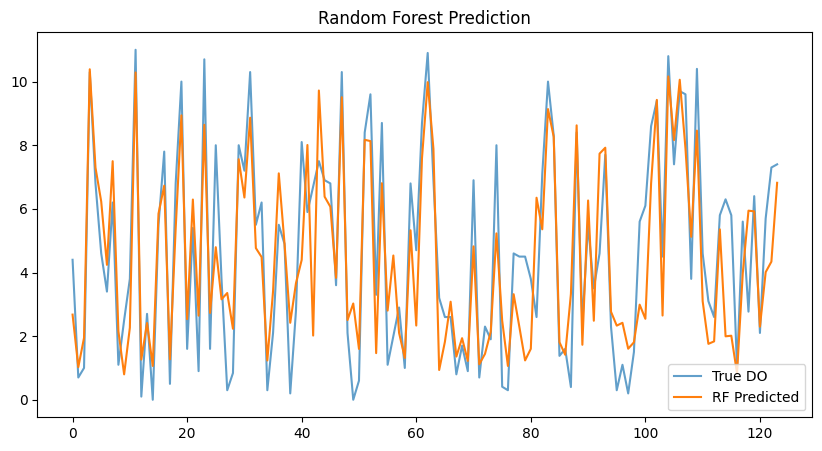

In [15]:
# ============================================
# 📉 Plot Prediction 
# ============================================

plt.figure(figsize=(10,5))
plt.plot(y_test, label='True DO', alpha=0.7)
plt.plot(y_pred_rf, label='RF Predicted')
plt.legend()
plt.title("Random Forest Prediction")
plt.show()

### 1.3.5 Visualize a Tree

We plot one of the decision trees from the Random Forest to see how it makes predictions using splits on input variables.


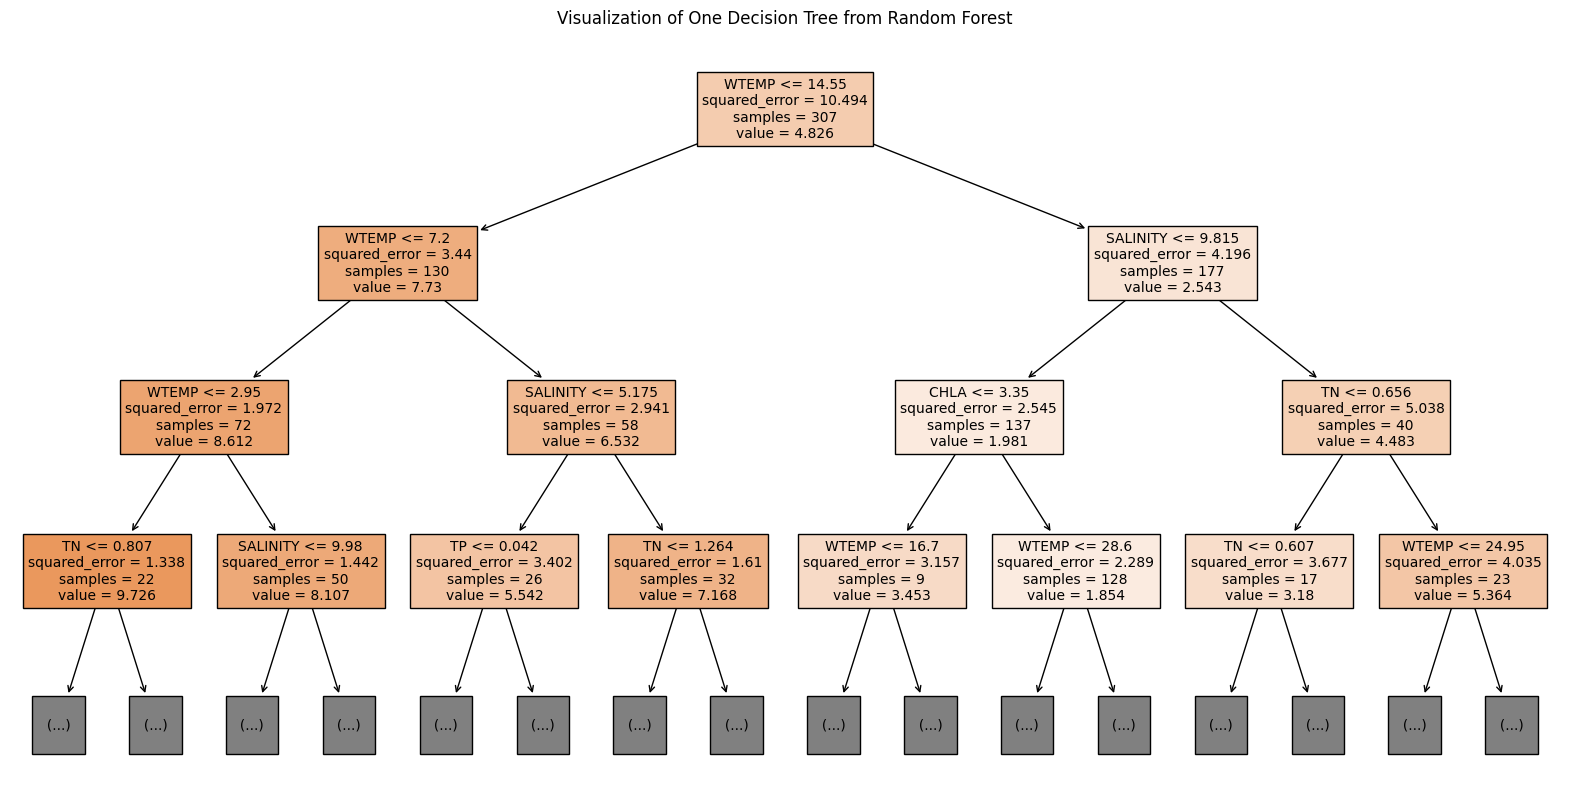

In [16]:
from sklearn.tree import plot_tree

# Define feature names if not already defined
features = ['CHLA', 'SALINITY', 'TN', 'TP', 'WTEMP']

plt.figure(figsize=(20, 10))
plot_tree(rf.estimators_[0], feature_names=features, filled=True, max_depth=3, fontsize=10)
plt.title("Visualization of One Decision Tree from Random Forest")
plt.show()


### 1.3.6 SHAP Interpretation

We use SHAP (SHapley Additive exPlanations) to interpret how each feature contributes to the Random Forest predictions.


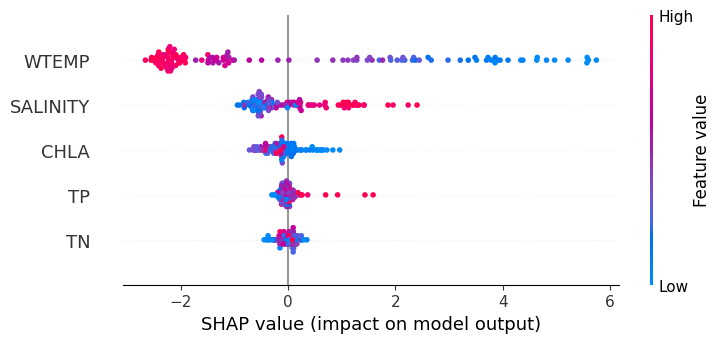

In [17]:
import shap
# Create explainer for RandomForest
explainer = shap.Explainer(rf, X_train,feature_names=features)

# Compute SHAP values with additivity check disabled
shap_values = explainer(X_test, check_additivity=False)
shap.plots.beeswarm(shap_values)

### 1.3.7 SHAP Bar Plot

This plot shows the average absolute contribution of each feature to model predictions.


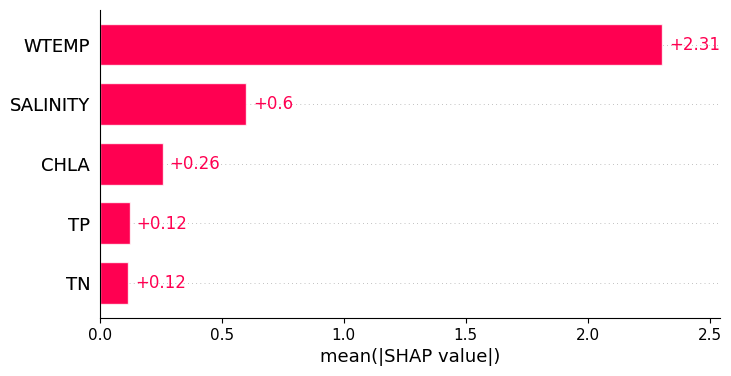

In [18]:
shap.plots.bar(shap_values)

### 1.3.8 SHAP Dependence Plots

We visualize how each input feature influences its SHAP value using a regression-style scatter plot.


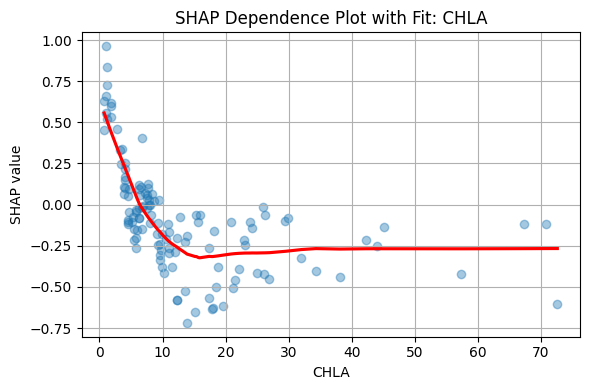

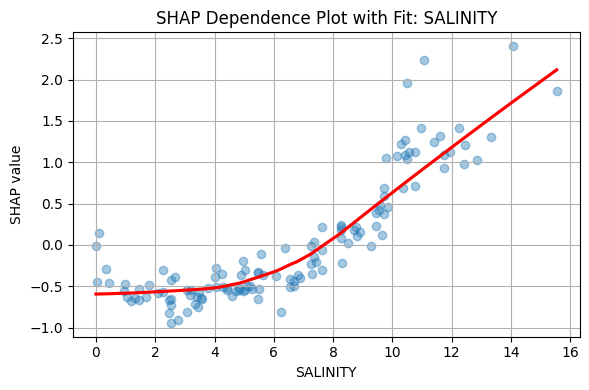

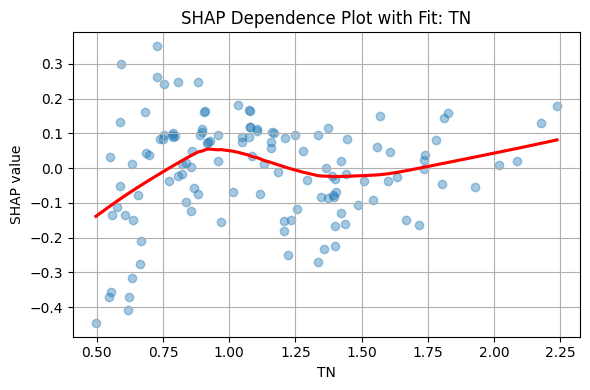

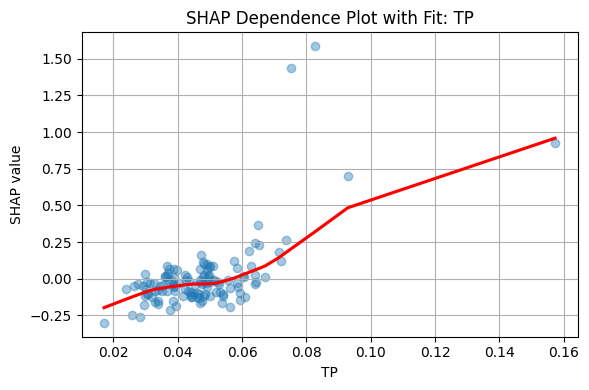

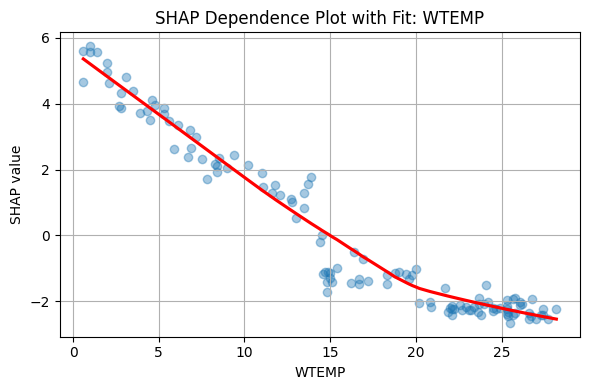

In [19]:
import seaborn as sns

# Make sure SHAP values are in array form
shap_array = shap_values.values  # shape: (n_samples, n_features)

# Plot for each feature
for i, name in enumerate(features):
    plt.figure(figsize=(6, 4))
    sns.regplot(
        x=X_test[:, i], 
        y=shap_array[:, i], 
        lowess=True, 
        scatter_kws={'alpha': 0.4}, 
        line_kws={'color': 'red'}
    )
    plt.xlabel(f"{name}")
    plt.ylabel("SHAP value")
    plt.title(f"SHAP Dependence Plot with Fit: {name}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### 1.3.9 Bonus: Test RF on Another Station

Want to test the Random Forest model trained on one station’s data using a cleaned dataset from a **different** station?



📍 Testing Trained Model on New Station Data
RMSE (other station): 1.8556251558861794
R² (other station): 0.7591777103458264


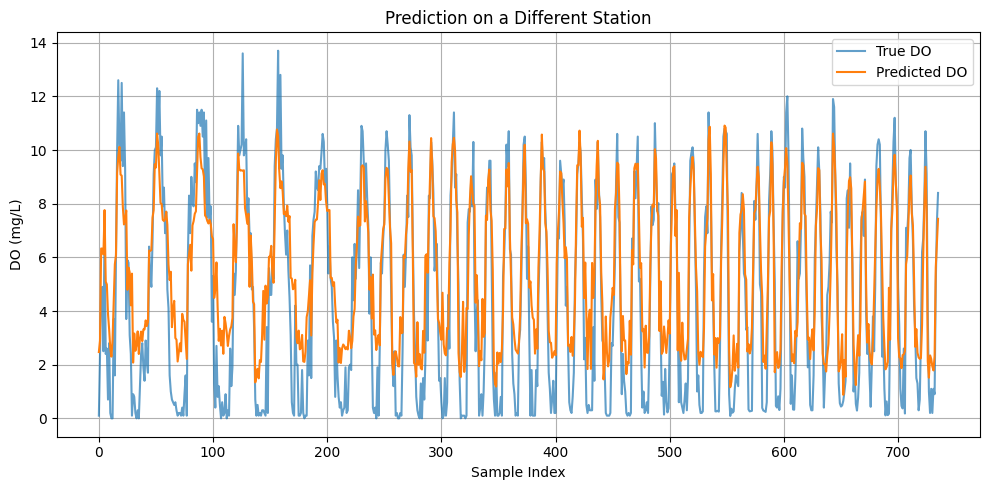

In [20]:
# Load external station dataset
test_station_file = "CBP_CleanedData/final_cleaned_dataset_CB5.1.csv"  # <- change this for different stations
df_test_other = pd.read_csv(test_station_file, parse_dates=["SampleDate"], index_col="SampleDate")

# Extract features and true DO
X_other = df_test_other[features].values
y_other = df_test_other["DO"].values

# Predict using the trained RF model
y_pred_other = rf.predict(X_other)

# Evaluate
print("\n📍 Testing Trained Model on New Station Data")
print("RMSE (other station):", mean_squared_error(y_other, y_pred_other, squared=False))
print("R² (other station):", r2_score(y_other, y_pred_other))

# Plot
plt.figure(figsize=(10, 5))
plt.plot(y_other, label="True DO", alpha=0.7)
plt.plot(y_pred_other, label="Predicted DO")
plt.legend()
plt.title("Prediction on a Different Station")
plt.xlabel("Sample Index")
plt.ylabel("DO (mg/L)")
plt.grid(True)
plt.tight_layout()
plt.show()

## 1.4 MLP Model

In this section, we build and train a simple neural network (MLP) to predict bottom DO using surface parameters. We’ll also visualize training loss and interpret results using SHAP values.


### 1.4.1 Load and Scale Data

Neural networks require scaled input features. We use `StandardScaler` to normalize the training and test data.


In [21]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 1.4.2 Build and Train the MLP

We define a 2-layer neural network and use early stopping to prevent overfitting. The model is trained using mean squared error (MSE) loss.


In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

mlp_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

mlp_model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = mlp_model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 27.5133 - val_loss: 19.3955
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step - loss: 18.5454 - val_loss: 10.8037
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/step - loss: 8.3464 - val_loss: 5.5029
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 490us/step - loss: 6.4847 - val_loss: 4.0637
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - loss: 4.2237 - val_loss: 3.4849
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step - loss: 4.5132 - val_loss: 3.1625
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - loss: 4.1150 - val_loss: 3.0486
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step - loss: 3.5553 - val_loss: 2.9331
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step - loss: 3.4357 - val_loss: 2.7963
Epoch 10/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step - loss: 3.2181 - val_loss: 2.7450
Epoch 11/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - loss: 3.6666 - val_loss: 2.7254
Epoch 12/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/st

### 1.4.3 Plot Training vs Validation Loss

We plot the MSE loss for both training and validation over epochs to assess learning dynamics.


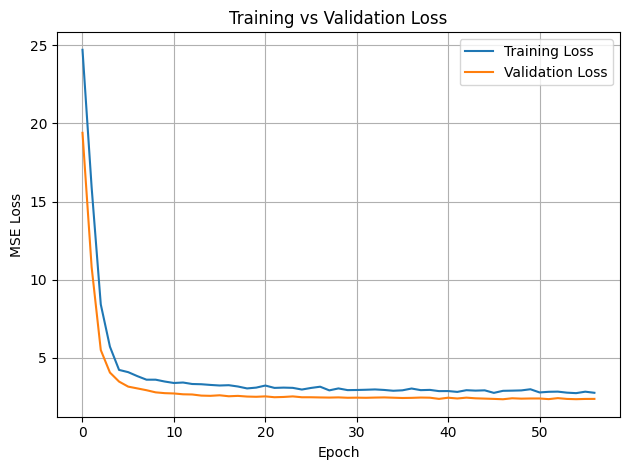

In [23]:

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 1.4.4 Predict and Evaluate MLP

We use the trained MLP model to predict on the test set and evaluate performance using RMSE and R².


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

🧠 MLP Model Results:
RMSE: 1.5638442856109636
R²: 0.7606277720718033


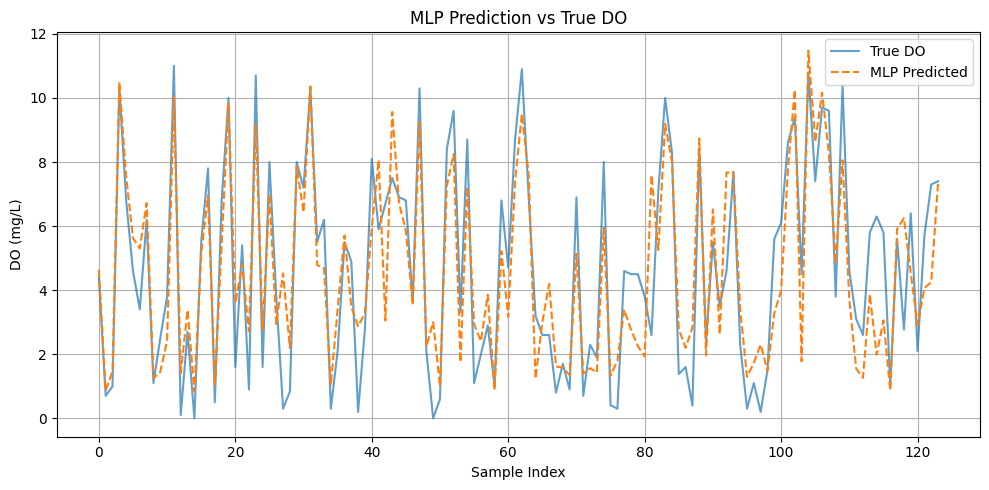

In [24]:
from sklearn.metrics import mean_squared_error, r2_score

# Predict on test set
y_pred_mlp = mlp_model.predict(X_test_scaled).flatten()

# Evaluation metrics
print("\n🧠 MLP Model Results:")
print("RMSE:", mean_squared_error(y_test, y_pred_mlp, squared=False))
print("R²:", r2_score(y_test, y_pred_mlp))

# Plot predictions vs true values
plt.figure(figsize=(10, 5))
plt.plot(y_test, label='True DO', alpha=0.7)
plt.plot(y_pred_mlp, label='MLP Predicted', linestyle='--')
plt.title("MLP Prediction vs True DO")
plt.xlabel("Sample Index")
plt.ylabel("DO (mg/L)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 1.4.5 SHAP Interpretation

We use SHAP values to understand how each surface feature contributes to DO predictions made by the MLP model.


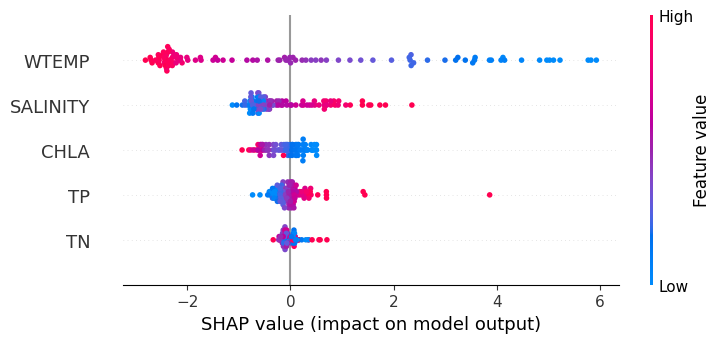

In [25]:

features = ['CHLA', 'SALINITY', 'TN', 'TP', 'WTEMP']
explainer = shap.Explainer(mlp_model, X_train_scaled, feature_names=features)

# Limit to first 100 test points for speed
shap_values = explainer(X_test_scaled[:100])

shap.plots.beeswarm(shap_values)

### 1.4.6 SHAP Dependence Plots

We visualize the relationship between feature values and SHAP contributions to better interpret the model's behavior.


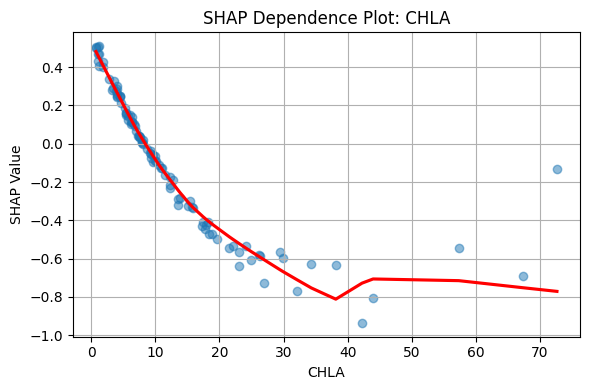

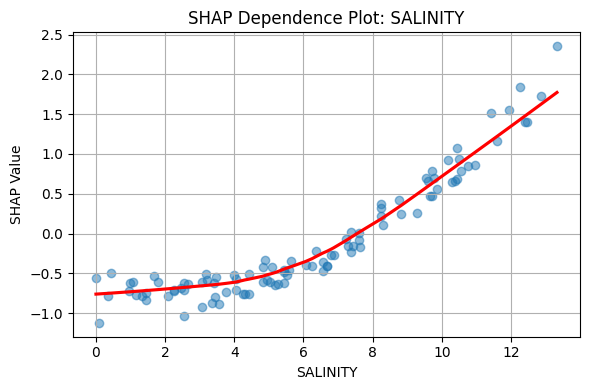

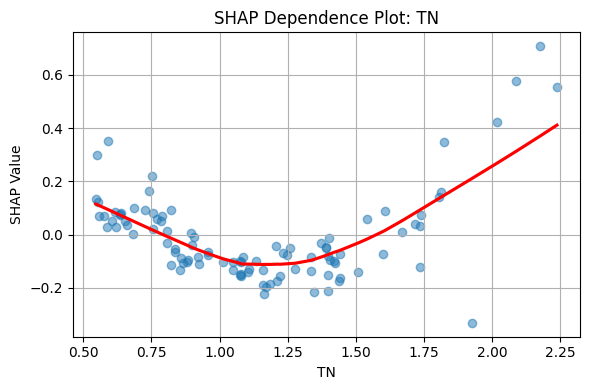

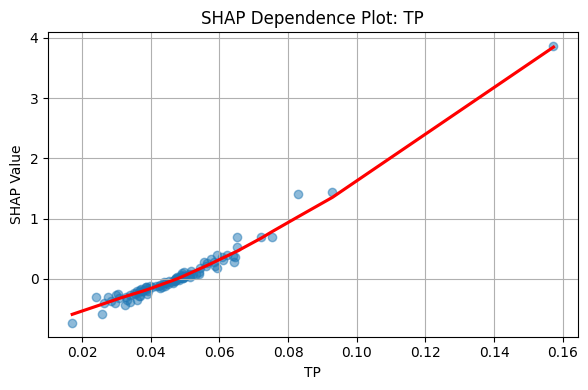

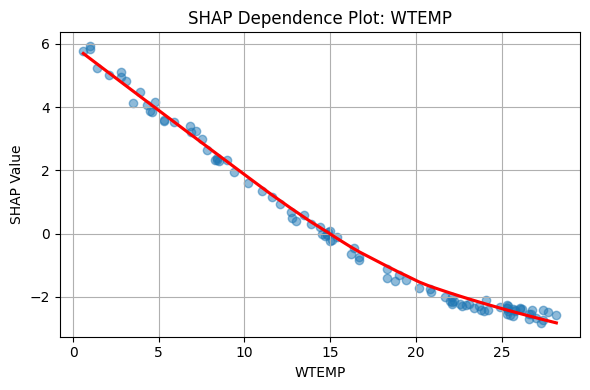

In [26]:

shap_df = pd.DataFrame(shap_values.values, columns=features)
input_df = pd.DataFrame(X_test[:100], columns=features)  # unscaled input

for feat in features:
    plt.figure(figsize=(6, 4))
    sns.regplot(
        x=input_df[feat],
        y=shap_df[feat],
        lowess=True,
        scatter_kws={'alpha': 0.5},
        line_kws={'color': 'red'}
    )
    plt.xlabel(feat)
    plt.ylabel("SHAP Value")
    plt.title(f"SHAP Dependence Plot: {feat}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### 1.4.7 Visualize MLP Architecture

This plot shows the structure of the MLP model including number of layers and connections.


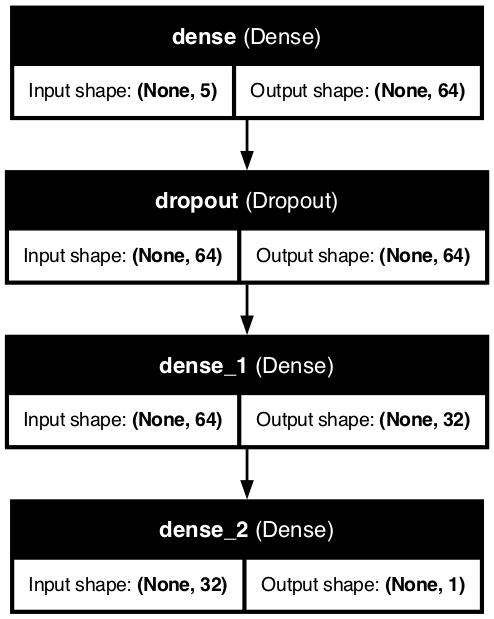

In [27]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image

# Save the architecture diagram to file
plot_model(
    mlp_model,
    to_file="mlp_architecture.png",
    show_shapes=True,
    show_layer_names=True,
    dpi=100
)

# Display in notebook
Image("mlp_architecture.png")

### 1.4.8 Bonus: Test MLP on Another Station

We evaluate how well the MLP model trained on one station performs on a dataset from a different location.


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step

🧪 Cross-Station Evaluation (MLP)
RMSE: 1.595290975601228
R²: 0.7523755349662806


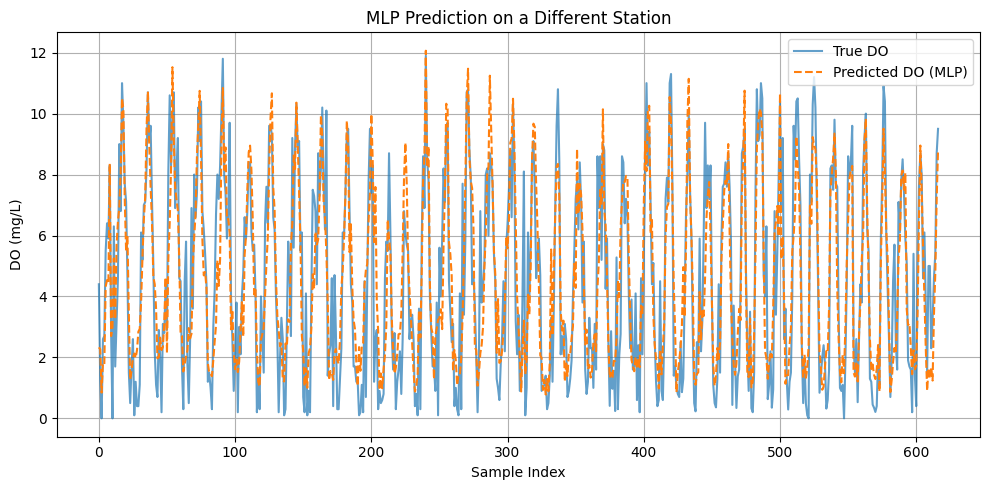

In [28]:
# === Load new station dataset (e.g., trained on CB5.1, test on CB3.2) ===
filename_other = "CBP_CleanedData/final_cleaned_dataset_CB3.2.csv"  # 👈 Change to another station if needed
df_other = pd.read_csv(filename_other, parse_dates=["SampleDate"], index_col="SampleDate")

# === Prepare input features and target ===
X_other = df_other[features].values
y_other = df_other["DO"].values
X_other_scaled = scaler.transform(X_other)  # ⚠️ use the same scaler from training

# === Predict with trained MLP ===
y_other_pred = mlp_model.predict(X_other_scaled).flatten()

# === Evaluate and plot ===
from sklearn.metrics import mean_squared_error, r2_score

print("\n🧪 Cross-Station Evaluation (MLP)")
print("RMSE:", mean_squared_error(y_other, y_other_pred, squared=False))
print("R²:", r2_score(y_other, y_other_pred))

plt.figure(figsize=(10, 5))
plt.plot(y_other, label="True DO", alpha=0.7)
plt.plot(y_other_pred, label="Predicted DO (MLP)", linestyle='--')
plt.title("MLP Prediction on a Different Station")
plt.xlabel("Sample Index")
plt.ylabel("DO (mg/L)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 1.5 Compare RF and MLP Predictions

This plot shows predictions from both models on the same test set. 


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


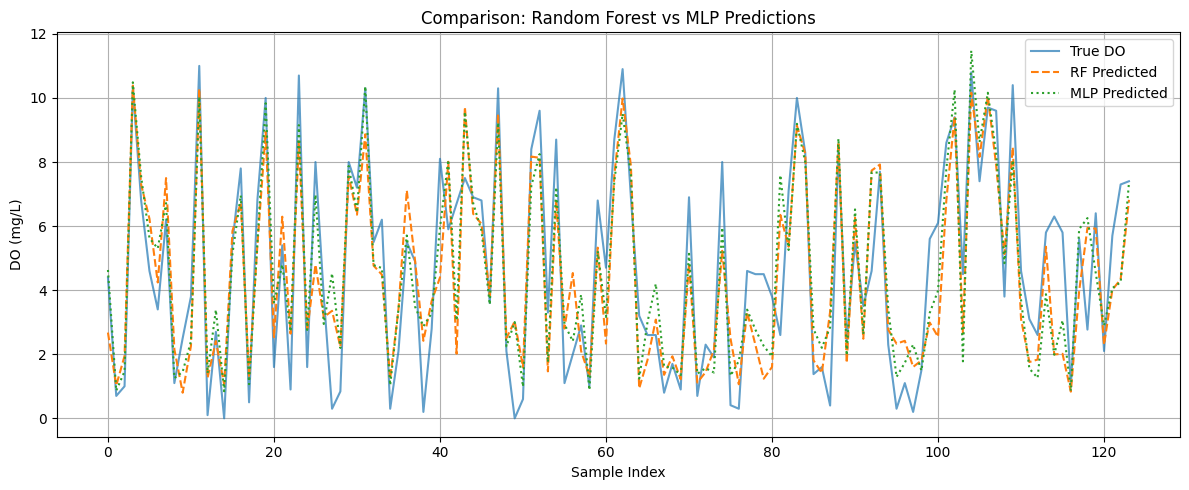

In [29]:
# Predict with MLP on test set
y_pred_mlp = mlp_model.predict(X_test_scaled).flatten()

# Plot comparison
plt.figure(figsize=(12, 5))
plt.plot(y_test, label='True DO', alpha=0.7)
plt.plot(y_pred_rf, label='RF Predicted', linestyle='--')
plt.plot(y_pred_mlp, label='MLP Predicted', linestyle=':')
plt.legend()
plt.title("Comparison: Random Forest vs MLP Predictions")
plt.xlabel("Sample Index")
plt.ylabel("DO (mg/L)")
plt.grid(True)
plt.tight_layout()
plt.show()

## Want to do some exercise?

In this section, you will experiment with model configurations to better understand how architecture and hyperparameters affect performance.

### Q1. Change the number of estimators in the Random Forest

**Go to section: 1.3.3 Train Random Forest Model**  

Look for the line:

rf = RandomForestRegressor(n_estimators=100, random_state=42)

Try values like `50`, `100`, `200`, or `500`.

### Q2. Change the number of neurons in the MLP model

##Go to section: 1.4.2 Build and Train the MLP**

Look for this code block:

mlp_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

Try to replace the value 64 and 32 with others

### Q3. Add or remove layers in the MLP model

##Go to section: 1.4.2 Build and Train the MLP**

You can make the network deeper:

mlp_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])

Or make it simpler:

mlp_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(1)
])